In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Random Forest Classifier

In [2]:
from sklearn.ensemble import RandomForestClassifier

In order to be clearer, I have previously narrowed the space search. Here is displayed the final step. Random forest training takes a lot of time to compute, so I will optimize only subset0 and then see if it generalizes well.

In [3]:
spaceForest  = [Integer(10, 20, name="min_samples_split"),
                Integer(1, 5, name="min_samples_leaf"),
                Integer(500, 900, name="n_estimators")]

In [4]:
@use_named_args(spaceForest)
def objectiveForest(**params):
    forest.set_params(**params)
    forest.fit(X_train,y_train)
    predict = forest.predict(X_test)
    e = f1_score(y_test, predict, average='micro')
    print(e, [(a, params[a]) for a in params])
    return 1 - e

In [5]:
X_train = pd.read_csv('Datasets/CV0_train_subset_step1_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
X_test = pd.read_csv('Datasets/CV0_test_subset_0.csv', index_col=0)
y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
forest = RandomForestClassifier(n_jobs=-1)
res_forest = gp_minimize(objectiveForest, spaceForest, n_calls=20, random_state=0)
1-res_forest.fun, res_forest.x[0], res_forest.x[1], res_forest.x[2]

0.7317344589409056 [('min_samples_split', 16), ('min_samples_leaf', 4), ('n_estimators', 843)]
0.7319263238679968 [('min_samples_split', 18), ('min_samples_leaf', 3), ('n_estimators', 654)]
0.7340752110514198 [('min_samples_split', 13), ('min_samples_leaf', 1), ('n_estimators', 609)]
0.7315425940138144 [('min_samples_split', 15), ('min_samples_leaf', 4), ('n_estimators', 692)]
0.7316193399846508 [('min_samples_split', 14), ('min_samples_leaf', 4), ('n_estimators', 635)]
0.7329048349961627 [('min_samples_split', 16), ('min_samples_leaf', 2), ('n_estimators', 883)]
0.7314274750575595 [('min_samples_split', 11), ('min_samples_leaf', 4), ('n_estimators', 689)]
0.7315425940138144 [('min_samples_split', 18), ('min_samples_leaf', 3), ('n_estimators', 772)]
0.7320222563315426 [('min_samples_split', 17), ('min_samples_leaf', 3), ('n_estimators', 715)]
0.7339409056024558 [('min_samples_split', 18), ('min_samples_leaf', 1), ('n_estimators', 689)]
0.7327129700690713 [('min_samples_split', 10), ('m

(0.7340752110514198, 13, 1, 609)

I must pay attention here : if the best model would have been the most prone to overfitting (900 estimators, 1 min samples leaf and 10 samples split) it would have been a clue that I were in the wrong direction. Fortunately, the optimization found a better model.

In [6]:
generalization = pd.Series(index=range(4))
for i in generalization.index:
    forest = RandomForestClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                    n_estimators=res_forest.x[2], n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step1_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
    forest.fit(X_train,y_train)
    predict = pd.DataFrame(forest.predict(X_test), columns=['RF']).set_index(X_test.index)
    predict.to_csv("Datasets/RF_predicted_step1_subset_{}.csv".format(i))
    generalization[i] = f1_score(y_test, predict, average='micro')
generalization

0    0.734075
1    0.729144
2    0.733461
3    0.735764
dtype: float64

Generalization is good, and this is my best model so far !

In [7]:
featuresRF = pd.Series(forest.feature_importances_, index=X_train.columns)
featuresRF.sort_values(ascending=False)

geo_level_mean                            0.291588
geo_level_ratio                           0.258370
age                                       0.068714
area_percentage                           0.060523
height_percentage                         0.040828
foundation_type_r                         0.021294
has_superstructure_mud_mortar_stone       0.018482
count_floors_pre_eq                       0.015275
ground_floor_type_v                       0.014656
roof_type_x                               0.010512
has_superstructure_timber                 0.010450
has_superstructure_cement_mortar_brick    0.010113
foundation_type_i                         0.009643
ground_floor_type_f                       0.009327
other_floor_type_q                        0.008555
has_secondary_use_agriculture             0.007798
land_surface_condition_t                  0.007590
position_s                                0.007149
has_superstructure_adobe_mud              0.007053
plan_configuration_mean        

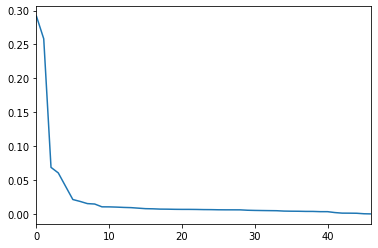

In [8]:
featuresRF.sort_values(ascending=False).plot(use_index=False)

In [9]:
for i in range(5):
    forest = RandomForestClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                    n_estimators=res_forest.x[2], n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step2_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    forest.fit(X_train,y_train)
    predict = pd.DataFrame(forest.predict(X_test), columns=['RF']).set_index(X_test.index)
    predict.to_csv("Datasets/RF_predicted_step2_subset_{}.csv".format(i))

In [10]:
forest = RandomForestClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                n_estimators=res_forest.x[2], n_jobs=-1)
X_train = pd.read_csv('Datasets/train_full_processed.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
X_val = pd.read_csv('Datasets/submission_processed.csv', index_col=0)
forest.fit(X_train,y_train)
predict = pd.DataFrame(forest.predict(X_val), columns=['RF']).set_index(X_val.index)
predict.to_csv("Datasets/RF_predicted_submission.csv")

# Extra Trees Classifier

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

In [12]:
generalization = pd.Series(index=range(4))
for i in generalization.index:
    extra = ExtraTreesClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                    n_estimators=res_forest.x[2], n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step1_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
    extra.fit(X_train,y_train)
    predict = pd.DataFrame(extra.predict(X_test), columns=['ET']).set_index(X_test.index)
    predict.to_csv("Datasets/ET_predicted_step1_subset_{}.csv".format(i))
    generalization[i] = f1_score(y_test, predict, average='micro')
generalization

0    0.727897
1    0.726132
2    0.729662
3    0.730775
dtype: float64

In [13]:
featuresET = pd.Series(extra.feature_importances_, index=X_train.columns)
featuresET.sort_values(ascending=False)

geo_level_ratio                           0.287779
geo_level_mean                            0.256730
age                                       0.049922
area_percentage                           0.045533
height_percentage                         0.039205
foundation_type_r                         0.026079
has_superstructure_mud_mortar_stone       0.022499
ground_floor_type_v                       0.018090
count_floors_pre_eq                       0.016241
has_superstructure_cement_mortar_brick    0.013967
roof_type_x                               0.012857
has_superstructure_timber                 0.011482
foundation_type_i                         0.011066
other_floor_type_q                        0.009430
ground_floor_type_f                       0.009272
has_superstructure_adobe_mud              0.009250
foundation_type_w                         0.008596
has_secondary_use_agriculture             0.008333
has_superstructure_mud_mortar_brick       0.008205
plan_configuration_ratio       

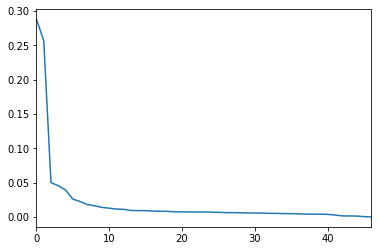

In [14]:
featuresET.sort_values(ascending=False).plot(use_index=False)

In [15]:
for i in range(5):
    extra = RandomForestClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                    n_estimators=res_forest.x[2], n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step2_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    extra.fit(X_train,y_train)
    predict = pd.DataFrame(extra.predict(X_test), columns=['RF']).set_index(X_test.index)
    predict.to_csv("Datasets/ET_predicted_step2_subset_{}.csv".format(i))

In [16]:
extra = RandomForestClassifier(min_samples_split=res_forest.x[0], min_samples_leaf=res_forest.x[1],
                                n_estimators=res_forest.x[2], n_jobs=-1)
X_train = pd.read_csv('Datasets/train_full_processed.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
X_val = pd.read_csv('Datasets/submission_processed.csv', index_col=0)
extra.fit(X_train,y_train)
predict = pd.DataFrame(extra.predict(X_val), columns=['RF']).set_index(X_val.index)
predict.to_csv("Datasets/ET_predicted_submission.csv")

# XGBoost Classifier

In [17]:
import xgboost as xgb

In [18]:
spaceXGB  = [Real(0.25, 0.4, name="colsample_bytree"),
             Real(0.35, 0.65, name="learning_rate"),
             Integer(400, 600, name="n_estimators"),
             Integer(3, 8, name="max_depth")]

In [19]:
@use_named_args(spaceXGB)
def objectiveXGB(**params):
    xgboost.set_params(**params)
    xgboost.fit(X_train,y_train)
    predict = xgboost.predict(X_test)
    e = f1_score(y_test, predict, average='micro')
    print(e, [(a, params[a]) for a in params])
    return 1 - e

In [20]:
X_train = pd.read_csv('Datasets/CV0_train_subset_step1_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]-1
X_test = pd.read_csv('Datasets/CV0_test_subset_0.csv', index_col=0)
y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]-1
xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3)
res_xgb = gp_minimize(objectiveXGB, spaceXGB, n_calls=25, random_state=0)
1-res_xgb.fun, res_xgb.x[0], res_xgb.x[1], res_xgb.x[2], res_xgb.x[3]

0.7265732924021489 [('colsample_bytree', 0.33892669273375275), ('learning_rate', 0.6032797245743053), ('n_estimators', 572), ('max_depth', 7)]
0.7299884881043746 [('colsample_bytree', 0.3435345545178959), ('learning_rate', 0.46531451218780995), ('n_estimators', 460), ('max_depth', 3)]
0.7307367613200308 [('colsample_bytree', 0.290898444187017), ('learning_rate', 0.493299535196405), ('n_estimators', 562), ('max_depth', 5)]
0.7295855717574827 [('colsample_bytree', 0.30891771941512447), ('learning_rate', 0.6008236290612133), ('n_estimators', 467), ('max_depth', 6)]
0.7286454336147353 [('colsample_bytree', 0.3052362309760822), ('learning_rate', 0.6371465476859139), ('n_estimators', 428), ('max_depth', 7)]
0.7289907904834996 [('colsample_bytree', 0.32104120679105663), ('learning_rate', 0.5902732255938934), ('n_estimators', 504), ('max_depth', 6)]
0.729911742133538 [('colsample_bytree', 0.3580948982088875), ('learning_rate', 0.5246059376225322), ('n_estimators', 507), ('max_depth', 7)]
0.730

(0.7328472755180353, 0.25, 0.35, 400, 8)

In [21]:
xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3,
                           colsample_bytree=0.3, learning_rate=0.5,
                           max_depth=5, n_estimators = 500)
xgboost.fit(X_train, y_train)
predict = pd.DataFrame(xgboost.predict(X_test), columns=['XGB']).set_index(X_test.index)
f1_score(y_test, predict, average='micro')

0.731964696853415

In [22]:
generalization = pd.Series(index=range(4))
for i in generalization.index:
    xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3,
                               colsample_bytree=res_xgb.x[0], learning_rate=res_xgb.x[1],
                               n_estimators=res_xgb.x[2], max_depth=res_xgb.x[3])
    X_train = pd.read_csv('Datasets/CV0_train_subset_step1_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]-1
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]-1
    xgboost.fit(X_train,y_train)
    predict = pd.DataFrame(xgboost.predict(X_test), columns=['XGB']).set_index(X_test.index)
    predict.to_csv("Datasets/XGB_predicted_step1_subset_{}.csv".format(i))
    generalization[i] = f1_score(y_test, predict, average='micro')
generalization

0    0.732847
1    0.728204
2    0.732502
3    0.732483
dtype: float64

In [23]:
for i in range(5):
    xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3,
                               colsample_bytree=res_xgb.x[0], learning_rate=res_xgb.x[1],
                               n_estimators=res_xgb.x[2], max_depth=res_xgb.x[3])
    X_train = pd.read_csv('Datasets/CV0_train_subset_step2_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]-1
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    xgboost.fit(X_train,y_train)
    predict = pd.DataFrame(xgboost.predict(X_test), columns=['XGB']).set_index(X_test.index)
    predict.to_csv("Datasets/XGB_predicted_step2_subset_{}.csv".format(i))

In [24]:
xgboost = xgb.XGBRegressor(booster='gbtree', objective ='multi:softmax',  num_class=3,
                               colsample_bytree=res_xgb.x[0], learning_rate=res_xgb.x[1],
                               n_estimators=res_xgb.x[2], max_depth=res_xgb.x[3])
X_train = pd.read_csv('Datasets/train_full_processed.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]-1
X_val = pd.read_csv('Datasets/submission_processed.csv', index_col=0)
xgboost.fit(X_train,y_train)
predict = pd.DataFrame(xgboost.predict(X_val), columns=['XGB']).set_index(X_val.index)
predict.to_csv("Datasets/XGB_predicted_submission.csv")

# Nearest neighbors classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In order to be clearer, I have previously narrowed the space search. Here is displayed the final step. Nearest neighbors classsifiers training takes a lot of time to compute, so I will optimize only subset0 and then see if it generalizes well.

In [26]:
spaceKNN  = [Integer(20, 30, name="n_neighbors"),
             Integer(25, 55, name="leaf_size")]

In [27]:
@use_named_args(spaceKNN)
def objectiveKNN(**params):
    knn.set_params(**params)
    knn.fit(X_train,y_train)
    predict = knn.predict(X_test)
    e = f1_score(y_test, predict, average='micro')
    print(e, [(a, params[a]) for a in params])
    return 1 - e

In [28]:
X_train = pd.read_csv('Datasets/CV0_train_subset_step1_0.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
X_test = pd.read_csv('Datasets/CV0_test_subset_0.csv', index_col=0)
y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
knn = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', leaf_size=10, p=2,
                            metric='minkowski', metric_params=None, n_jobs=-1)
res_KNN = gp_minimize(objectiveKNN, spaceKNN, n_calls=20, random_state=0)
1-res_KNN.fun, res_KNN.x[0], res_KNN.x[1]

0.7043745203376822 [('n_neighbors', 26), ('leaf_size', 50)]
0.7049309286262472 [('n_neighbors', 29), ('leaf_size', 50)]
0.7044704528012279 [('n_neighbors', 26), ('leaf_size', 37)]
0.7043553338449732 [('n_neighbors', 23), ('leaf_size', 27)]
0.7045088257866462 [('n_neighbors', 23), ('leaf_size', 39)]
0.7042594013814275 [('n_neighbors', 28), ('leaf_size', 39)]
0.7041634689178818 [('n_neighbors', 24), ('leaf_size', 50)]
0.7045088257866462 [('n_neighbors', 23), ('leaf_size', 44)]
0.7041634689178818 [('n_neighbors', 24), ('leaf_size', 54)]
0.7041442824251727 [('n_neighbors', 21), ('leaf_size', 51)]
0.7041250959324635 [('n_neighbors', 30), ('leaf_size', 25)]
0.7041059094397544 [('n_neighbors', 20), ('leaf_size', 25)]
0.7041250959324635 [('n_neighbors', 30), ('leaf_size', 25)]
0.7041634689178818 [('n_neighbors', 30), ('leaf_size', 55)]
0.7041059094397544 [('n_neighbors', 20), ('leaf_size', 25)]
0.7040291634689179 [('n_neighbors', 20), ('leaf_size', 55)]
0.7041250959324635 [('n_neighbors', 30),

(0.7049309286262472, 29, 50)

In [29]:
generalization = pd.Series(index=range(4))
for i in generalization.index:
    knn = KNeighborsClassifier(n_neighbors=res_KNN.x[0], weights='uniform', algorithm='auto', leaf_size=res_KNN.x[1], p=2,
                            metric='minkowski', metric_params=None, n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step1_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    y_test= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_test.index]["damage_grade"]
    knn.fit(X_train,y_train)
    predict = pd.DataFrame(knn.predict(X_test), columns=['KNN']).set_index(X_test.index)
    predict.to_csv("Datasets/KNN_predicted_step1_subset_{}.csv".format(i))
    generalization[i] = f1_score(y_test, predict, average='micro')
generalization

0    0.704931
1    0.701074
2    0.705679
3    0.706869
dtype: float64

In [30]:
for i in range(5):
    knn = KNeighborsClassifier(n_neighbors=res_KNN.x[0], weights='uniform', algorithm='auto', leaf_size=res_KNN.x[1], p=2,
                            metric='minkowski', metric_params=None, n_jobs=-1)
    X_train = pd.read_csv('Datasets/CV0_train_subset_step2_{}.csv'.format(i), index_col=0)
    y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
    X_test = pd.read_csv('Datasets/CV0_test_subset_{}.csv'.format(i), index_col=0)
    knn.fit(X_train,y_train)
    predict = pd.DataFrame(knn.predict(X_test), columns=['KNN']).set_index(X_test.index)
    predict.to_csv("Datasets/KNN_predicted_step2_subset_{}.csv".format(i))

In [31]:
knn = KNeighborsClassifier(n_neighbors=res_KNN.x[0], weights='uniform', algorithm='auto', leaf_size=res_KNN.x[1], p=2,
                            metric='minkowski', metric_params=None, n_jobs=-1)
X_train = pd.read_csv('Datasets/train_full_processed.csv', index_col=0)
y_train= pd.read_csv('Datasets/train_labels.csv', index_col=0).loc[X_train.index]["damage_grade"]
X_val = pd.read_csv('Datasets/submission_processed.csv', index_col=0)
knn.fit(X_train,y_train)
predict = pd.DataFrame(knn.predict(X_val), columns=['KNN']).set_index(X_val.index)
predict.to_csv("Datasets/KNN_predicted_submission.csv")

Generalization is very good. However, I expected better results from this model.